In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F

import os

import matplotlib.pyplot as plt
from PIL import Image

from albumentations.pytorch import ToTensorV2
import albumentations as A

import numpy as np

from tqdm import tqdm

import torchvision.models as models

In [18]:
class LyftUdacity(Dataset):
    def __init__(self,img_dir,transform = None):
        self.transforms = transform
        image_paths = [i+'/CameraRGB' for i in img_dir]
        seg_paths = [i+'/CameraSeg' for i in img_dir]
        self.images,self.masks = [],[]
        
        for i in image_paths:
            imgs = os.listdir(i)
            self.images.extend([i+'/'+img for img in imgs])
        for i in seg_paths:
            masks = os.listdir(i)
            self.masks.extend([i+'/'+mask for mask in masks])
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        #print(self.images[index])
        img = np.array(Image.open(self.images[index]))
        mask = np.array(Image.open(self.masks[index]))
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            mask = torch.max(mask,dim=2)[0]
        return img,mask

In [19]:
data_dir = ['data/Semantic Segmentation for Self Driving Cars/data'+i+'/data'+i for i in ['A','B','C','D','E']]

In [20]:
def get_images(image_dir,transform = None,batch_size=16,shuffle=True,pin_memory=True):
    data = LyftUdacity(image_dir,transform = t1)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch

In [21]:
t1 = A.Compose([
    A.Resize(160,240),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [22]:
data_train,data_test = get_images(data_dir, transform=t1, batch_size=16)

In [23]:
id = 12
data = LyftUdacity(data_dir,transform = t1)


torch.unique(data[0][1])

tensor([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12], dtype=torch.uint8)

In [26]:
class CNA(nn.Module):
    def __init__(self, in_nc, out_nc, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_nc, out_nc, kernel_size=3, stride=stride, padding=1)
        self.norm = nn.BatchNorm2d(out_nc)
        self.act = nn.GELU()
    
    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.act(out)
        
        return out

In [27]:
class UnetBlock(nn.Module):
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()
        
        self.conv1 = CNA(in_nc, inner_nc, stride=2)
        self.conv2 = CNA(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = CNA(inner_nc, inner_nc)
        self.conv_cat = nn.Conv2d(inner_nc+in_nc, out_nc, 3, padding=1)
    
    def forward(self, x):
        _,_,h,w = x.shape
        
        inner = self.conv1(x)
        inner = self.conv2(inner)
        if self.inner_block is not None:
            inner = self.inner_block(inner)
        inner = self.conv3(inner)
        inner = F.upsample(inner, size=(h,w), mode='bilinear')
        inner = torch.cat((x, inner), axis=1)
        
        out = self.conv_cat(inner)
        
        return out

In [28]:
class Unet(nn.Module):
    def __init__(self, in_nc=1, nc=32, out_nc=1, num_downs=4):
        super().__init__()
        
        self.cna1= CNA(3, nc)
        self.cna2= CNA(nc, nc)
        
        unetblock = None
        for i in range(num_downs-3):
            unetblock = UnetBlock(8*nc, 8*nc, 8*nc, unetblock)
        unetblock = UnetBlock(4*nc, 8*nc, 4*nc, unetblock)
        unetblock = UnetBlock(2*nc, 4*nc, 2*nc, unetblock)
        self.unetblock = UnetBlock(nc, 2*nc, nc, unetblock)
        
        self.cna3= CNA(nc, nc)
        
        self.conv_last = nn.Conv2d(nc, out_nc, 3, padding=1)
        
    def forward(self, x):
        
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unetblock(out)
        out = self.cna3(out)
        out = self.conv_last(out)
        
        
        return out

In [29]:
device = 'cuda'
unet_model = Unet(in_nc=3, nc=32, out_nc=13, num_downs=7)
unet_model = unet_model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [30]:
epochs = 15

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(data_train)):
        X, y = sample
        
        X = X.to(device)
        y = y.to(device)
        y = y.type(torch.LongTensor)
        

        pred = unet_model(X)
        
        loss = loss_fn(pred.to('cpu'), y.to('cpu'))
        
        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item
        
        optimizer.step()
        optimizer.zero_grad()
        
        pbar.set_description(f'loss: {loss_item:.5f}')
    
    scheduler.step()
    
    print(f'epoch: {epoch + 1}')    
    print(f'loss: {loss_val/len(data_train)}')

loss: 0.35346: 100%|██████████| 250/250 [01:42<00:00,  2.45it/s]


epoch: 1
loss: 0.7229916286468506


loss: 0.21990: 100%|██████████| 250/250 [01:41<00:00,  2.47it/s]


epoch: 2
loss: 0.27625552415847776


loss: 0.17759: 100%|██████████| 250/250 [01:39<00:00,  2.50it/s]


epoch: 3
loss: 0.19785789161920547


loss: 0.16914: 100%|██████████| 250/250 [01:40<00:00,  2.48it/s]


epoch: 4
loss: 0.16455532425642014


loss: 0.13675: 100%|██████████| 250/250 [01:43<00:00,  2.42it/s]


epoch: 5
loss: 0.14483409500122071


loss: 0.11926: 100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


epoch: 6
loss: 0.13085381200909615


loss: 0.11164: 100%|██████████| 250/250 [01:38<00:00,  2.53it/s]


epoch: 7
loss: 0.11944438371062278


loss: 0.11619: 100%|██████████| 250/250 [01:39<00:00,  2.51it/s]


epoch: 8
loss: 0.11168494176864624


loss: 0.11537: 100%|██████████| 250/250 [01:39<00:00,  2.51it/s]


epoch: 9
loss: 0.10614942568540574


loss: 0.09511: 100%|██████████| 250/250 [01:39<00:00,  2.51it/s]


epoch: 10
loss: 0.10149307668209076


loss: 0.10324: 100%|██████████| 250/250 [01:39<00:00,  2.52it/s]


epoch: 11
loss: 0.09763524705171585


loss: 0.09516: 100%|██████████| 250/250 [01:38<00:00,  2.53it/s]


epoch: 12
loss: 0.09457711100578309


loss: 0.08483: 100%|██████████| 250/250 [01:38<00:00,  2.54it/s]


epoch: 13
loss: 0.09181179288029671


loss: 0.08863: 100%|██████████| 250/250 [01:39<00:00,  2.52it/s]


epoch: 14
loss: 0.08941557785868645


loss: 0.07623: 100%|██████████| 250/250 [01:39<00:00,  2.52it/s]

epoch: 15
loss: 0.0873354947566986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


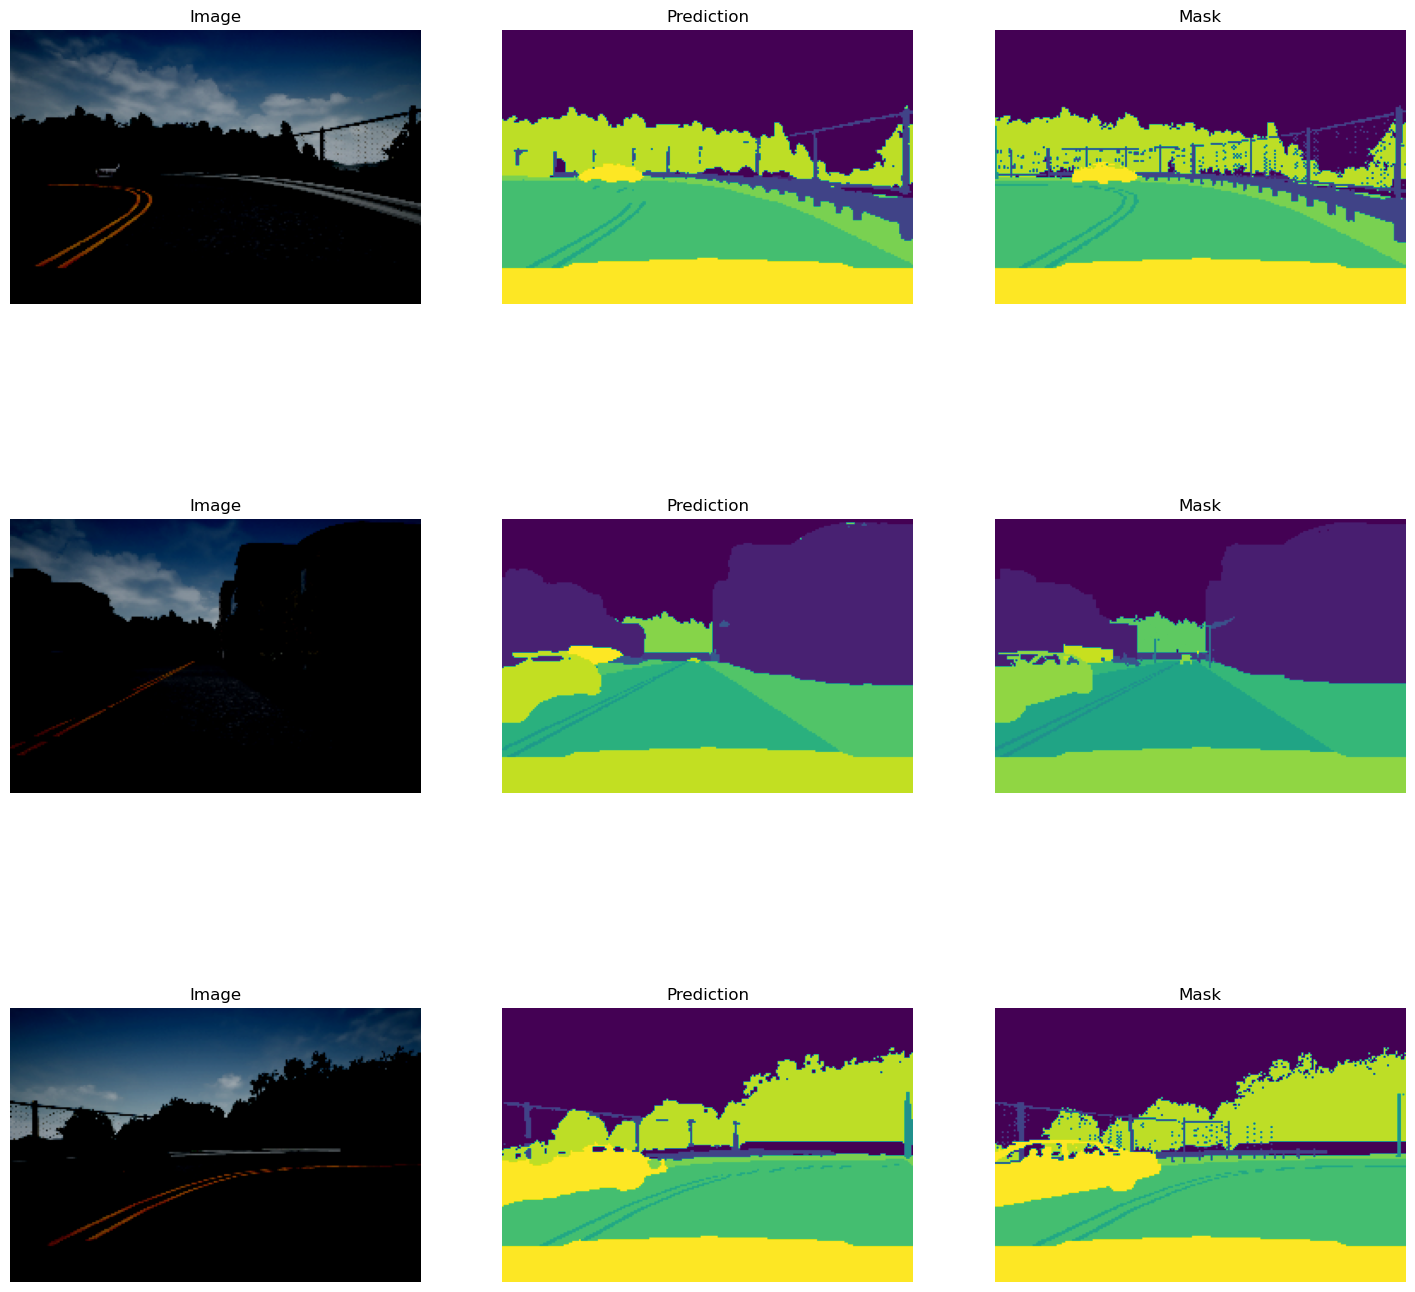

In [28]:
for x,y in data_test:
    x = x.to(device)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(unet_model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break